<a href="https://colab.research.google.com/github/GuQiangJS/finance-tools-py/blob/master/jupyters/%E6%8C%87%E6%A0%87%E7%9B%B8%E5%85%B3%E6%80%A7%E6%B5%8B%E8%AF%95_%E5%8A%A8%E9%87%8F%E6%8C%87%E6%A0%87_MFI_Money_Flow_Index_%E8%B5%84%E9%87%91%E6%B5%81%E9%87%8F%E6%8C%87%E6%A0%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 初步结论：不要纠结在是否是14日的指标。看上去结果还不错，可以有机会避免站在山顶上。

## 安装思源字体

这样显示好看点。呵呵！

In [0]:
import os
noto_font_path='/usr/share/fonts/NotoSansCJKsc-Medium.otf'
if not os.path.exists(noto_font_path):
    !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKsc-hinted.zip"
    !unzip "NotoSansCJKsc-hinted.zip"
    !mv NotoSansCJKsc-Medium.otf /usr/share/fonts/
from IPython.display import clear_output
clear_output(True)

## 安装第三方库。

[talib](https://www.fmz.com/bbs-topic/1234)，[finance-tools-py](https://github.com/GuQiangJS/finance-tools-py)

In [0]:
try:
    import talib
except ModuleNotFoundError:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    import talib
try:
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import MFI
    from finance_tools_py.simulation.callbacks import Rolling_Future
except ModuleNotFoundError:
    !pip install git+https://github.com/GuQiangJS/finance-tools-py.git -U
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import MFI
    from finance_tools_py.simulation.callbacks import Rolling_Future
clear_output(True)

## 其他相关引用

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# sns.set()
%matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 6)
plt.style.use('ggplot')

fontprop = matplotlib.font_manager.FontProperties(fname=noto_font_path)
matplotlib.font_manager.fontManager.ttflist += matplotlib.font_manager.createFontList([noto_font_path])
plt.rcParams['font.family'] = fontprop.get_name()

plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import warnings
warnings.filterwarnings('ignore')

# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## 读取数据

1. 读取交易日期、开盘价、最高价、最低价、收盘价、成交量。所有数据均取**前复权**数据。

In [0]:
def read_data(symbol='600036'):
    data=pd.read_csv('https://raw.githubusercontent.com/GuQiangJS/temp/master/{}_daily.csv'.format(symbol),parse_dates=True,
                    usecols=['date','open_qfq','high_qfq','low_qfq','close_qfq','volume_qfq'])
    data['date']=pd.to_datetime(data['date'])
    data.rename(columns={'open_qfq':'open','high_qfq':'high','low_qfq':'low','close_qfq':'close','volume_qfq':'volume'},inplace=True)
    data['preclose']=data['close'].shift()
    data['nextclose']=data['close'].shift(-1)
    data['nextchange']=data['nextclose']-data['close']
    data['nextchange_sign']=np.sign(data['nextchange'])
    return data

## 指标应用原则

应用法则

1. 显示超买超卖是MFI指标最基本的功能。当MFI>80时为超买，在其回头向下跌破80时，为短线卖出时机。
2. 当MFI<20时为超卖，当其回头向上突破20时，为短线买进时机。
3. 当MFI>80，而产生背离现象时，视为卖出信号。
4. 当MFI<20，而产生背离现象时，视为买进信号。

注意要点

1. 经过长期测试，MFI指标的背离讯号更能忠实的反应股价的反转现象。一次完整的波段行情，至少都会维持一定相当的时间，反转点出现的次数并不会太多。
2. 将MFI指标的参数设定为14天时，其背离讯号产生的时机，大致上都能和股价的顶点吻合。因此在使用MFI指标时，参数设定方面应尽量维持14日的原则。

## 数据处理

In [0]:
class Rolling_Future_New(Rolling_Future):
    def on_preparing_data(self, data, **kwargs):
        super().on_preparing_data(data, **kwargs)
        data['未来涨跌']=np.sign(data['rolling_{}_{}_mean'.format(self.col_name,self.timeperiod)]-data[self.col_name])
        data.rename(columns={'rolling_close_{}_mean/close'.format(self.timeperiod):'未来 {} 日均价/当前'.format(self.timeperiod)},inplace=True)

## 绘图

In [0]:
from tqdm.auto import tqdm
import datetime

from finance_tools_py.backtest import BackTest
from finance_tools_py.backtest import AllInChecker
import plotly.graph_objects as go

def plot(data,x,y,buy=None,sell=None):
    plot_ly(data,x,y,buy,sell).show()
    plot_py(data,x,y,buy,sell)
    plt.show()

def plot_ly(data,x,y,buy=None,sell=None):
    fig = go.Figure()
    for y1 in y:
        fig.add_trace(go.Scatter(x=data[x], y=data[y1],mode='lines',name=y1))
    if buy:
        b=data[data[x].isin(buy)]
        fig.add_trace(go.Scatter(x=b[x], y=b['close'],mode='markers',marker=dict(color="red",size=6)))
    if sell:
        b=data[data[x].isin(sell)]
        fig.add_trace(go.Scatter(x=b[x], y=b['close'],mode='markers',marker=dict(color="green",size=6)))
    return fig

def plot_py(data,x,y,buy=None,sell=None):
    fig=plt.figure(figsize=(22,8))
    for y1 in y:
        sns.lineplot(data=data,x=x,y=y1)
    if buy:
        b=data[data[x].isin(buy)]
        plt.plot(b[x], b['close'],'r.')
    if sell:
        b=data[data[x].isin(sell)]
        plt.plot(b[x], b['close'],'gx')
    return fig

class Checker(AllInChecker):
    
    def on_calc_buy_amount(self,
                           date: datetime.datetime.timestamp,
                           code: str,
                           price: float,
                           cash: float) -> float:
        # 每次最多买1/5
        return super().on_calc_buy_amount(date,code,price,cash*0.25)

    def on_check_sell(self,
                      date: datetime.datetime.timestamp,
                      code: str,
                      price: float,
                      cash: float,
                      hold_amount: float,
                      hold_price: float) -> bool:
        """当 `date` 及 `code` 包含在参数 :py:attr:`sell_dict` 中时返回 `True` 。否则返回 `False` 。"""
        if hold_amount>0 and hold_price*1.15>price:
            return False
        if code in self.sell_dict.keys() and date in self.sell_dict[code]:
            return True
        else:
            return False


def test_mfi(symbol,day,**kwargs):
    data=read_data(symbol)
    s=Simulation(data,'',callbacks=[MFI(day)])
    s.simulate()
    s.data['code']=symbol
    sell=s.data[s.data['mfi_{}'.format(day)]>80]['date']
    buy=s.data[s.data['mfi_{}'.format(day)]<20]['date']
    
    backtest=kwargs.pop('backtest',True)
    if backtest:
        bt = BackTest(s.data, init_cash=10000, callbacks=[Checker(
            buy_dict={symbol: buy.dt.to_pydatetime()},
            sell_dict={symbol: sell.dt.to_pydatetime()})])
        bt.calc_trade_history(verbose=0)
        if kwargs.pop('print_report',True):
            print(bt.report(show_history=kwargs.pop('show_history',False)))
    if kwargs.pop('plot',True):
        plot(s.data,x='date',
            y=['close'],
            buy=list(buy.values),
            sell=list(sell.values)
            )
    return bt if backtest else None

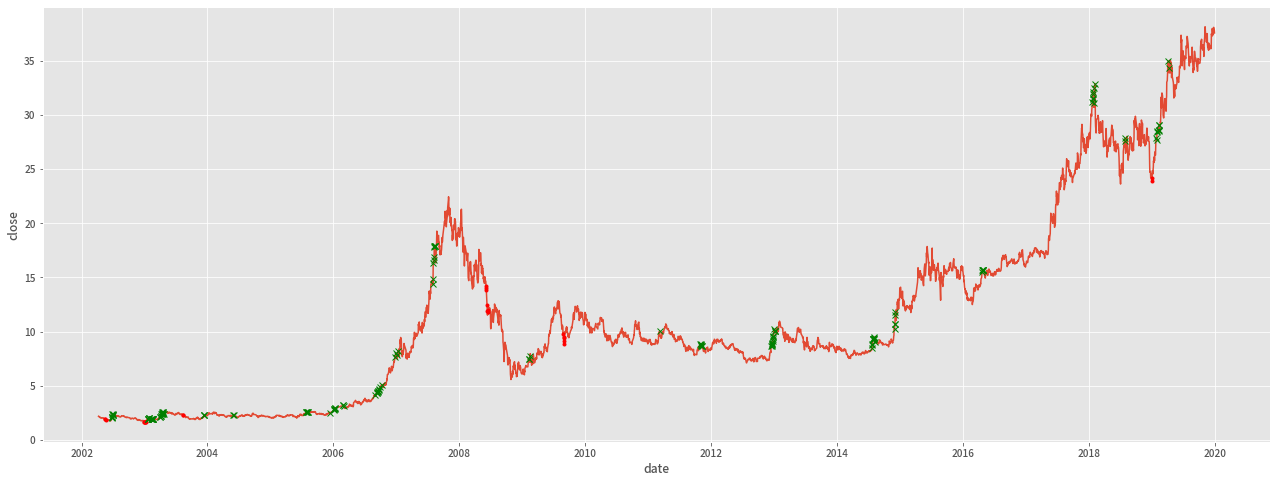

In [130]:
test_mfi('600036',20,backtest=False)


数据时间:1994-05-06 00:00:00~2020-03-09 00:00:00（可交易天数5860）
初始资金:10000.00
交易次数:92 (买入/卖出各算1次)
可用资金:6786.98
当前持仓:        buy_price   amount  price_cur
code                                 
600858   6.363415  35600.0        4.5
当前总资产:166986.98(现金+持股现价值)
资金变化率:67.87%
资产变化率:1669.87%
总手续费:1818.91
总印花税:1710.82


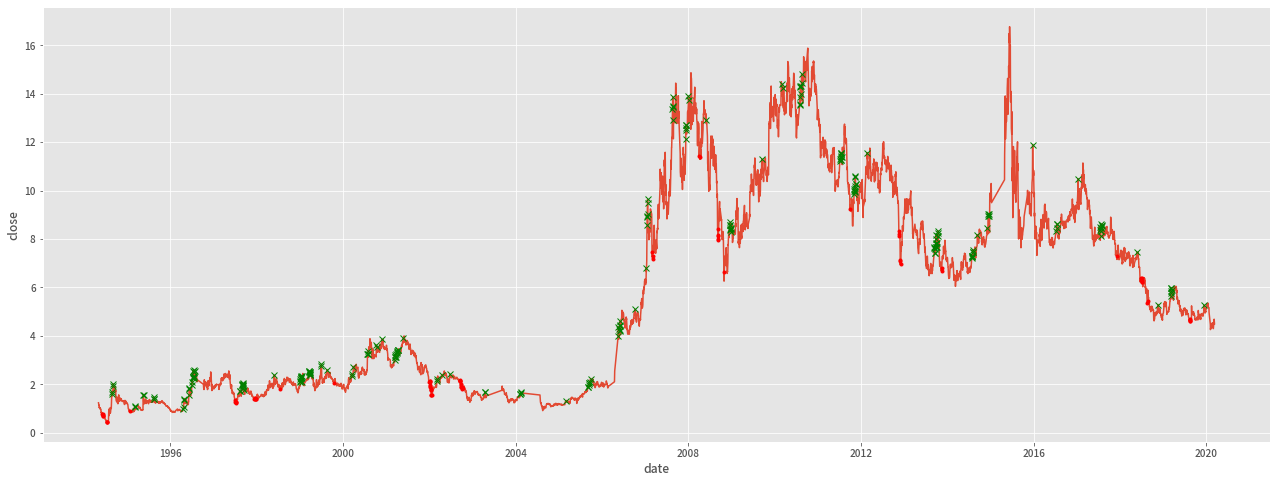

In [131]:
test_mfi('600858',20)

## 模拟回测

### 600036 14日：交易52次，资产变化率:253.14%


数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:52 (买入/卖出各算1次)
可用资金:25314.50
当前持仓:无
当前总资产:25314.50(现金+持股现价值)
资金变化率:253.14%
资产变化率:253.14%
总手续费:313.33
总印花税:179.10


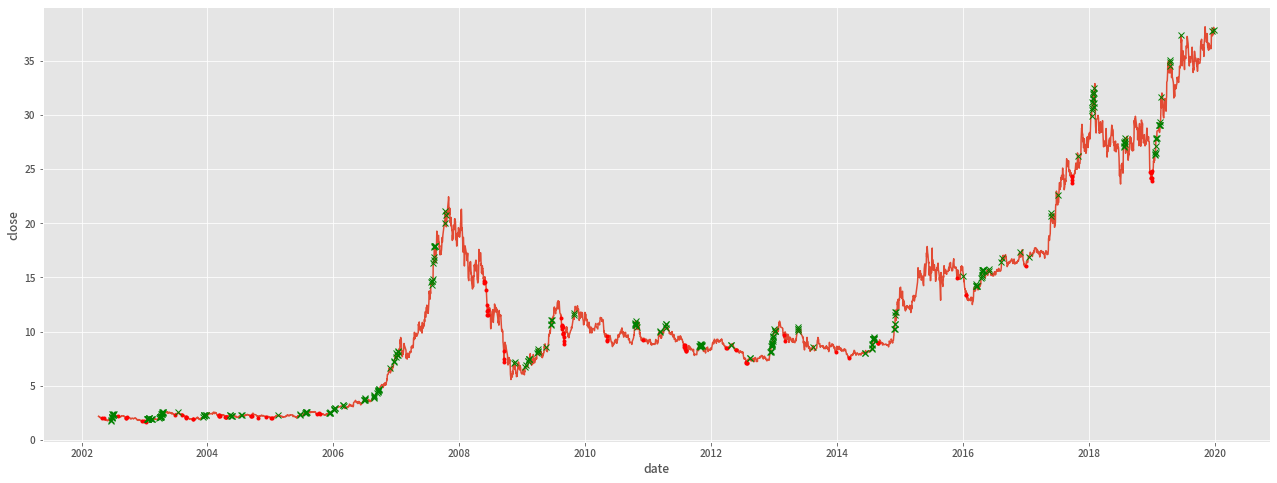

In [132]:
test_mfi('600036',14)

### 600858 14日：交易161次，资产变化率:992.87%


数据时间:1994-05-06 00:00:00~2020-03-09 00:00:00（可交易天数5860）
初始资金:10000.00
交易次数:161 (买入/卖出各算1次)
可用资金:1637.11
当前持仓:        buy_price   amount  price_cur
code                                 
600858   7.503808  21700.0        4.5
当前总资产:99287.11(现金+持股现价值)
资金变化率:16.37%
资产变化率:992.87%
总手续费:1978.48
总印花税:1653.78


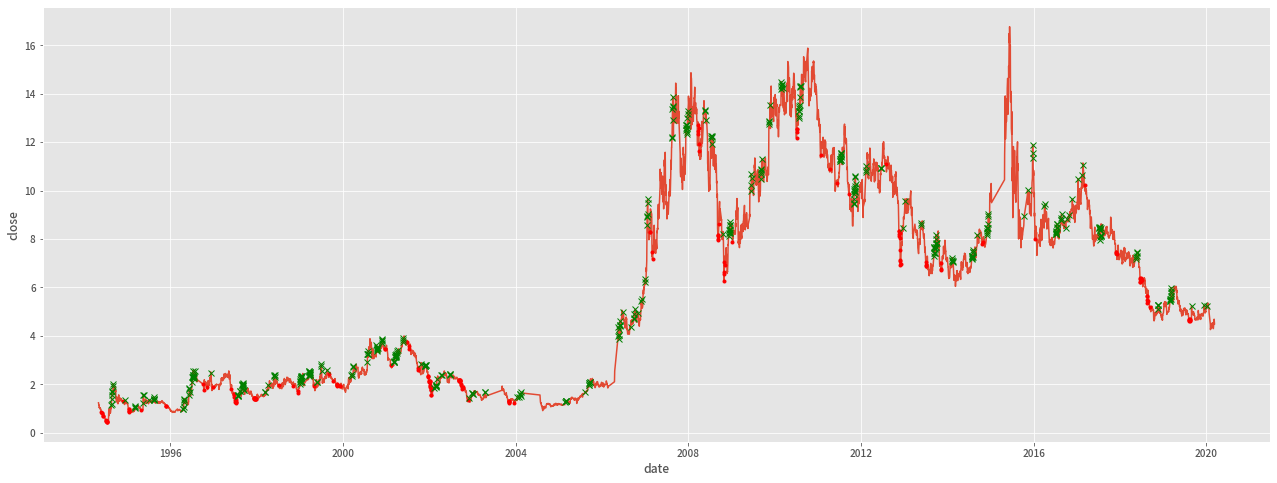

In [133]:
test_mfi('600858',14)

## 遍历回测

In [134]:
dfs=[]
for day in tqdm(range(5,60)):
    for symbol in ('600036','600858'):
        bt=test_mfi(symbol,day,print_report=False,plot=False)
        df=pd.DataFrame({'day':[day],
                                'symbol':[symbol],
                                'available_cash':[bt.available_cash],
                                'total_assets_cur':[bt.total_assets_cur],
                                'trade_times':[len(bt.history_df)]})
        print(df)
        dfs.append(df)

clear_output(True)

   day  symbol  available_cash  total_assets_cur  trade_times
0    5  600036    11426.616838      56522.616838          124


   day  symbol  available_cash  total_assets_cur  trade_times
0    5  600858     1851.756387     153951.756387          302


   day  symbol  available_cash  total_assets_cur  trade_times
0    6  600036    12923.356639      42987.356639           93


   day  symbol  available_cash  total_assets_cur  trade_times
0    6  600858      1417.50866      104017.50866          263


   day  symbol  available_cash  total_assets_cur  trade_times
0    7  600036    10532.165314      40596.165314           90


   day  symbol  available_cash  total_assets_cur  trade_times
0    7  600858     1580.447338     156830.447338          279


   day  symbol  available_cash  total_assets_cur  trade_times
0    8  600036    10714.249923      37020.249923           82


   day  symbol  available_cash  total_assets_cur  trade_times
0    8  600858       1307.3169       180857.3169          283


   day  symbol  available_cash  total_assets_cur  trade_times
0    9  600036    10520.167045      36826.167045           90


   day  symbol  available_cash  total_assets_cur  trade_times
0    9  600858     1578.229331      99228.229331          240


   day  symbol  available_cash  total_assets_cur  trade_times
0   10  600036     12083.76737       38389.76737           79


   day  symbol  available_cash  total_assets_cur  trade_times
0   10  600858     1471.866909     129271.866909          236


   day  symbol  available_cash  total_assets_cur  trade_times
0   11  600036    14946.995219      29978.995219           70


   day  symbol  available_cash  total_assets_cur  trade_times
0   11  600858     1418.429367     130568.429367          214


   day  symbol  available_cash  total_assets_cur  trade_times
0   12  600036    19571.277794      30845.277794           70


   day  symbol  available_cash  total_assets_cur  trade_times
0   12  600858     1417.833095      32017.833095          150


   day  symbol  available_cash  total_assets_cur  trade_times
0   13  600036    25944.344489      25944.344489           55


   day  symbol  available_cash  total_assets_cur  trade_times
0   13  600858     1430.049542      70280.049542          157


   day  symbol  available_cash  total_assets_cur  trade_times
0   14  600036    25314.498888      25314.498888           52


   day  symbol  available_cash  total_assets_cur  trade_times
0   14  600858     1637.107134      99287.107134          161


   day  symbol  available_cash  total_assets_cur  trade_times
0   15  600036    21968.696635      21968.696635           46


   day  symbol  available_cash  total_assets_cur  trade_times
0   15  600858     1593.812671      50193.812671          124


   day  symbol  available_cash  total_assets_cur  trade_times
0   16  600036    20735.276518      20735.276518           37


   day  symbol  available_cash  total_assets_cur  trade_times
0   16  600858     1665.827948     131265.827948          130


   day  symbol  available_cash  total_assets_cur  trade_times
0   17  600036    21838.459604      21838.459604           36


   day  symbol  available_cash  total_assets_cur  trade_times
0   17  600858     1449.263026      80199.263026          114


   day  symbol  available_cash  total_assets_cur  trade_times
0   18  600036    19224.594268      19224.594268           31


   day  symbol  available_cash  total_assets_cur  trade_times
0   18  600858     1773.656447     163323.656447          129


   day  symbol  available_cash  total_assets_cur  trade_times
0   19  600036    16283.745634      16283.745634           25


   day  symbol  available_cash  total_assets_cur  trade_times
0   19  600858     1978.067867     174778.067867          114


   day  symbol  available_cash  total_assets_cur  trade_times
0   20  600036    17381.191608      17381.191608           26


   day  symbol  available_cash  total_assets_cur  trade_times
0   20  600858     6786.984841     166986.984841           92


   day  symbol  available_cash  total_assets_cur  trade_times
0   21  600036    16785.741211      16785.741211           24


   day  symbol  available_cash  total_assets_cur  trade_times
0   21  600858     9762.986781     133512.986781           64


   day  symbol  available_cash  total_assets_cur  trade_times
0   22  600036    15475.741062      15475.741062           22


   day  symbol  available_cash  total_assets_cur  trade_times
0   22  600858     12508.74902      168208.74902           67


   day  symbol  available_cash  total_assets_cur  trade_times
0   23  600036    16613.546363      16613.546363           19


   day  symbol  available_cash  total_assets_cur  trade_times
0   23  600858     18466.99889      119716.99889           56


   day  symbol  available_cash  total_assets_cur  trade_times
0   24  600036    16008.689885      16008.689885           16


   day  symbol  available_cash  total_assets_cur  trade_times
0   24  600858    43247.515049      85097.515049           40


   day  symbol  available_cash  total_assets_cur  trade_times
0   25  600036    21480.308474      21480.308474           12


   day  symbol  available_cash  total_assets_cur  trade_times
0   25  600858     17073.03821       64323.03821           38


   day  symbol  available_cash  total_assets_cur  trade_times
0   26  600036     19456.38084       19456.38084           11


   day  symbol  available_cash  total_assets_cur  trade_times
0   26  600858    11662.720636      21562.720636           26


   day  symbol  available_cash  total_assets_cur  trade_times
0   27  600036    13087.425702      13087.425702           10


   day  symbol  available_cash  total_assets_cur  trade_times
0   27  600858     7609.548118      11659.548118           19


   day  symbol  available_cash  total_assets_cur  trade_times
0   28  600036    13741.254938      13741.254938            9


   day  symbol  available_cash  total_assets_cur  trade_times
0   28  600858     8738.802494      13238.802494           21


   day  symbol  available_cash  total_assets_cur  trade_times
0   29  600036    12634.750636      12634.750636            6


   day  symbol  available_cash  total_assets_cur  trade_times
0   29  600858    11279.067154      13529.067154           16


   day  symbol  available_cash  total_assets_cur  trade_times
0   30  600036    16367.041733      16367.041733            7


   day  symbol  available_cash  total_assets_cur  trade_times
0   30  600858     9416.569923      11216.569923           10


   day  symbol  available_cash  total_assets_cur  trade_times
0   31  600036    11327.466197      11327.466197            4


   day  symbol  available_cash  total_assets_cur  trade_times
0   31  600858    11624.533253      11624.533253            6


   day  symbol  available_cash  total_assets_cur  trade_times
0   32  600036    10726.179245      10726.179245            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   32  600858    13790.798173      13790.798173            5


   day  symbol  available_cash  total_assets_cur  trade_times
0   33  600036    10805.631215      10805.631215            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   33  600858    12451.564226      12451.564226            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   34  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   34  600858    16891.852475      16891.852475            4


   day  symbol  available_cash  total_assets_cur  trade_times
0   35  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   35  600858    18871.506496      18871.506496            4


   day  symbol  available_cash  total_assets_cur  trade_times
0   36  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   36  600858    20054.733482      20054.733482            4


   day  symbol  available_cash  total_assets_cur  trade_times
0   37  600036    11322.891749      11322.891749            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   37  600858    28416.052794      28416.052794            4


   day  symbol  available_cash  total_assets_cur  trade_times
0   38  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   38  600858    14146.777385      14146.777385            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   39  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   39  600858    14562.267047      14562.267047            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   40  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   40  600858    14706.976406      14706.976406            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   41  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   41  600858    14050.575871      14050.575871            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   42  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   42  600858    15153.241129      15153.241129            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   43  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   43  600858    15138.214808      15138.214808            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   44  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   44  600858    14458.791573      14458.791573            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   45  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   45  600858    14756.364534      14756.364534            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   46  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   46  600858    15131.059981      15131.059981            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   47  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   47  600858    14995.757286      14995.757286            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   48  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   48  600858    14995.757286      14995.757286            2


   day  symbol  available_cash  total_assets_cur  trade_times
0   49  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   49  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   50  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   50  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   51  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   51  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   52  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   52  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   53  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   53  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   54  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   54  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   55  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   55  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   56  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   56  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   57  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   57  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   58  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   58  600858           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   59  600036           10000             10000            0


   day  symbol  available_cash  total_assets_cur  trade_times
0   59  600858           10000             10000            0



In [135]:
df_all=pd.concat(dfs)
df_all

,day,symbol,available_cash,total_assets_cur,trade_times
0,5,600036,11426.616838,56522.616838,124
0,5,600858,1851.756387,153951.756387,302
0,6,600036,12923.356639,42987.356639,93
0,6,600858,1417.508660,104017.508660,263
0,7,600036,10532.165314,40596.165314,90
...,...,...,...,...,...
0,57,600858,10000.000000,10000.000000,0
0,58,600036,10000.000000,10000.000000,0
0,58,600858,10000.000000,10000.000000,0
0,59,600036,10000.000000,10000.000000,0


In [0]:
df_all['套牢资金']=df_all['total_assets_cur']-df_all['available_cash']
df_all['p']=(df_all['total_assets_cur']-10000)/df_all['trade_times']

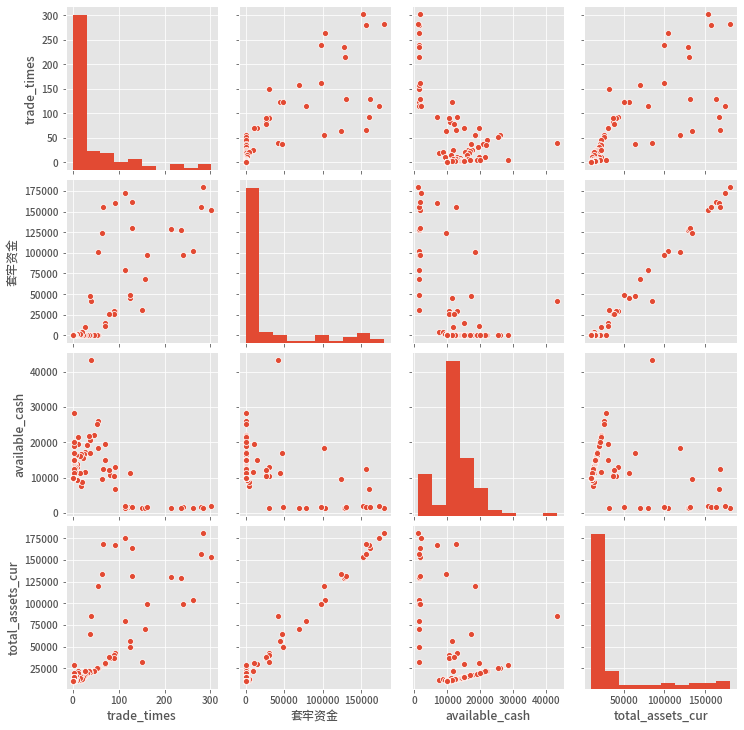

In [137]:
sns.pairplot(data=df_all[['trade_times','套牢资金','available_cash','total_assets_cur']])

交易次数小于10次的不容易被套牢

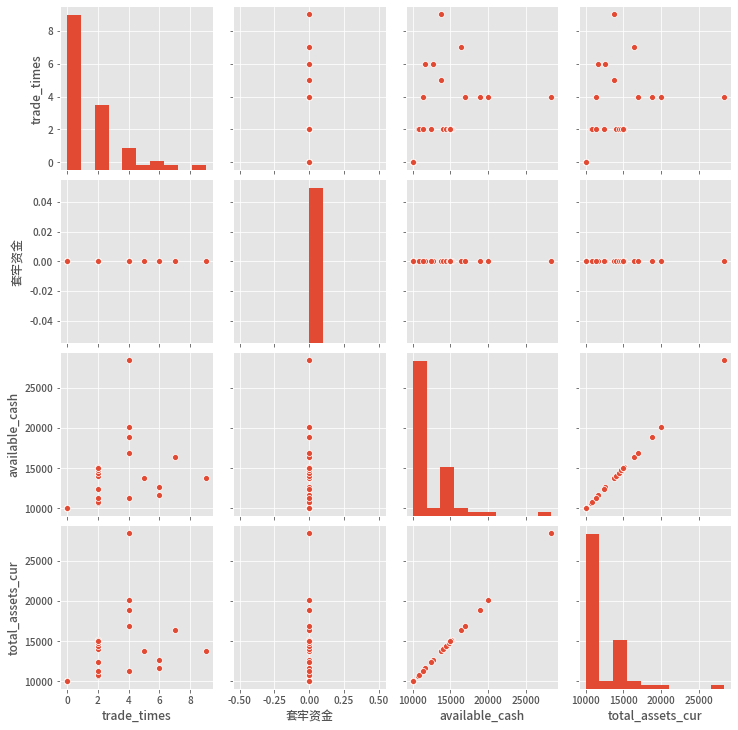

In [138]:
sns.pairplot(data=df_all[df_all['trade_times']<10][['trade_times','套牢资金','available_cash','total_assets_cur']])

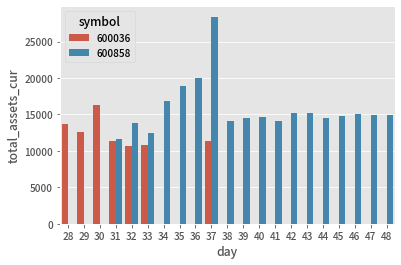

In [139]:
sns.barplot(data=df_all[(df_all['trade_times']>0) & (df_all['trade_times']<10)],x='day',y='total_assets_cur',hue='symbol')

In [140]:
df_all[(df_all['trade_times']>0) & (df_all['trade_times']<10) & (df_all['symbol']=='600858')].sort_values('p',ascending=False)

,day,symbol,available_cash,total_assets_cur,trade_times,套牢资金,p
0,37,600858,28416.052794,28416.052794,4,0.0,4604.013198
0,42,600858,15153.241129,15153.241129,2,0.0,2576.620565
0,43,600858,15138.214808,15138.214808,2,0.0,2569.107404
0,46,600858,15131.059981,15131.059981,2,0.0,2565.529991
0,36,600858,20054.733482,20054.733482,4,0.0,2513.683371
0,48,600858,14995.757286,14995.757286,2,0.0,2497.878643
0,47,600858,14995.757286,14995.757286,2,0.0,2497.878643
0,45,600858,14756.364534,14756.364534,2,0.0,2378.182267
0,40,600858,14706.976406,14706.976406,2,0.0,2353.488203
0,39,600858,14562.267047,14562.267047,2,0.0,2281.133523


In [141]:
df_all[(df_all['trade_times']>0) & (df_all['trade_times']<10) & (df_all['symbol']=='600036')].sort_values('p',ascending=False)

,day,symbol,available_cash,total_assets_cur,trade_times,套牢资金,p
0,30,600036,16367.041733,16367.041733,7,0.0,909.577390
0,37,600036,11322.891749,11322.891749,2,0.0,661.445875
0,29,600036,12634.750636,12634.750636,6,0.0,439.125106
0,28,600036,13741.254938,13741.254938,9,0.0,415.694993
0,33,600036,10805.631215,10805.631215,2,0.0,402.815607
0,32,600036,10726.179245,10726.179245,2,0.0,363.089622
0,31,600036,11327.466197,11327.466197,4,0.0,331.866549



数据时间:1994-05-06 00:00:00~2020-03-09 00:00:00（可交易天数5860）
初始资金:10000.00
交易次数:4 (买入/卖出各算1次)
可用资金:28416.05
当前持仓:无
当前总资产:28416.05(现金+持股现价值)
资金变化率:284.16%
资产变化率:284.16%
总手续费:34.46
总印花税:30.43
交易历史：
    datetime    code     price  amount          cash  commission        tax         total  toward
0 1994-07-04  600858  0.542717  4500.0   7550.333147    5.000000   2.442225   2449.666853       1
1 1995-05-22  600858  1.578638 -4500.0  14639.995500    7.103870   7.103870   7118.077833      -1
2 2002-09-24  600858  1.962279  1800.0  11099.360372    5.000000   3.532103   3540.635128       1
3 2007-01-22  600858  9.639664 -1800.0  28416.052794   17.351395  17.351395  17386.098003      -1


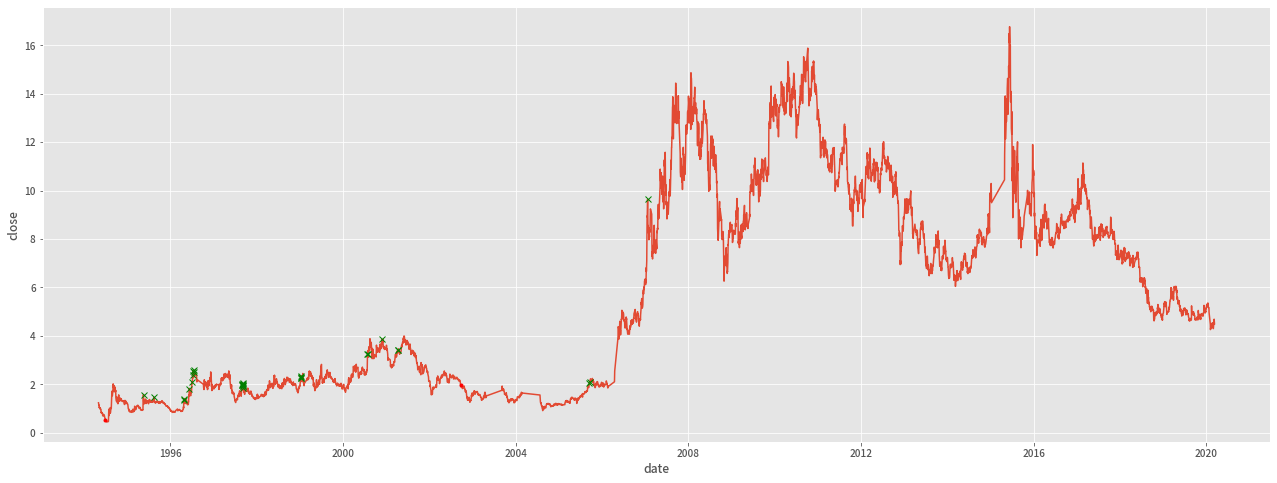

In [142]:
test_mfi('600858',37,show_history=True)


数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:2 (买入/卖出各算1次)
可用资金:11322.89
当前持仓:无
当前总资产:11322.89(现金+持股现价值)
资金变化率:113.23%
资产变化率:113.23%
总手续费:10.00
总印花税:6.28
交易历史：
    datetime    code     price  amount          cash  commission       tax        total  toward
0 2003-09-08  600036  2.057750  1200.0   7523.231206           5  2.469299  2476.768794       1
1 2006-02-27  600036  3.173724 -1200.0  11322.891749           5  3.808469  3817.277481      -1


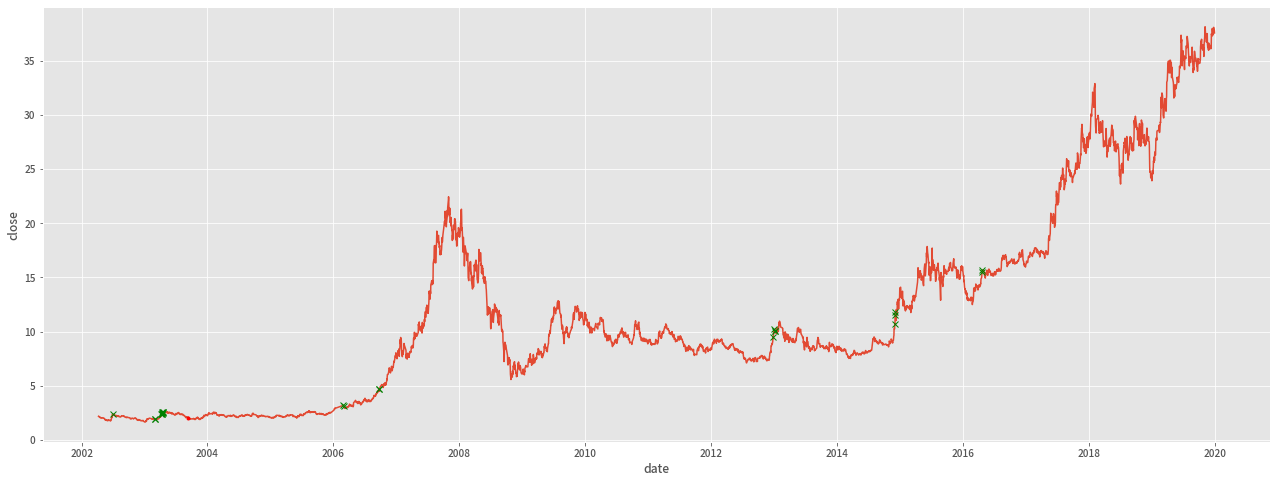

In [143]:
test_mfi('600036',37,show_history=True)